In [2]:
# Import packages
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

# Project Presentation

### Colette Yeager

## Topic

- Factors that have an influence on election results

- Determine which factors are most important in predicting future results

## Features

- Popular Vote Share vs Electoral College Share

- Voter Turnout

- Swing State Results

- Previous President's Features

- Economic Growth

## Methods

- Anticipated using both pd.read_html and Beautiful Soup

- Multiple different visualization tactics

- Would like to test mutliple different machine learning models

    - Modeling Pipeline with tuning

#### Current Tools

- So far have mostly just used read_html - data I've found has been in a table format already

- Pandas functions

- Creating functions

- Plotnine ggplot and matplotlib

In [3]:
# Election Results

# Import data
data1 = pd.read_excel("/Users/coletteyeager/Desktop/Code/PPOL564_FinalProject/Data/statistic_id1034688_share-of-electoral-and-popular-votes-by-each-united-states-president-1789-2020 (1).xlsx", sheet_name = "Data")
# Clean the data
results = data1[4:]
results.rename(columns={'Unnamed: 0': 'x1', 'Unnamed: 1':'President', 'Unnamed: 2': 'Electoral College', 'Unnamed: 3': 'Popular Vote', 'Unnamed: 4': 'x2'}, inplace=True)
results.drop(['x1'], axis = 1, inplace = True)
results.drop(['x2'], axis = 1, inplace = True)
results = results.replace('-', np.nan)
# Get the year
results[['President', 'Year']] = results.President.str.split(pat = '(', n = 1, expand = True)
results.Year = results.Year.str[:-1]
# Reverse order
results = results[::-1]
results.reset_index(drop = True, inplace = True)
# Set column types
results = results.astype({'Year': int, 'Electoral College': float, 'Popular Vote': float})
results = results[['Year', 'President', 'Electoral College', 'Popular Vote']]

In [4]:
# Prev Pres

def standardize_party(string):
    if string == "Unaffiliated":
        string = "GW"
    if string == "Federalist":
        string = "F"
    if string == "Democratic-Republican":
        string = "DR"
    if string == "Democratic":
        string = "D"
    if string == "Whig":
        string = "W"
    if string == "Republican":
        string = "R"
    return string

# Pull data
url = "http://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States"
content = pd.read_html(url)
prev_pres = pd.concat(content)
prev_pres = prev_pres[10:92]

# Drop columns
prev_pres.drop(columns =[0, 1, 'Party[b]', 'Politics of the United States', 
                 'Portrait', 'Vice President','vteChief executives of the United States', 
                 'vteChief executives of the United States.1', 
                 'vteLists related to the presidents and vice presidents of the United States', 
                 'vteLists related to the presidents and vice presidents of the United States.1', 
                 'vtePresidents of the United States', 'vtePresidents of the United States.1'], 
               axis = 1, inplace = True)
prev_pres.drop_duplicates(inplace = True)
# Get rid of rows where a President changes party midway through
prev_pres.drop_duplicates(subset = ['Election', 'Name(Birth–Death)'], keep='first', inplace = True)
# Get rid of rows where a President wasn't elected - started in position from assassination of previous
prev_pres.drop_duplicates(subset = ['Election'], keep = 'first', inplace = True)

# Clean column content
prev_pres['Name(Birth–Death)'] = prev_pres['Name(Birth–Death)'].str.split('(').str[0]
prev_pres['Name(Birth–Death)'] = prev_pres['Name(Birth–Death)'].str.split('[').str[0]
prev_pres.rename(columns ={'Election': 'Year', 'Name(Birth–Death)': 'Name', "Party[b].1": 'Party', "Presidency[a]": 'Presidency', 'Presidency[a].1': 'Years in Office'}, inplace = True)
prev_pres.Year[0] = '1789'
prev_pres = prev_pres.astype({'Year': int, 'Presidency': int})

# Change party to be shortened form
prev_pres.Party = prev_pres.Party.apply(standardize_party)
# Fix individual places
prev_pres['Party'][11] = "Adams"
prev_pres['Party'][27] = "R"

In [5]:
# Economic Growth

# Read in data
data2 = pd.read_excel("/Users/coletteyeager/Desktop/Code/PPOL564_FinalProject/Data/statistic_id996758_annual-gdp-growth-for-the-united-states-1930-2020 (1).xlsx", sheet_name = "Data")

# Get necessary columns and fix types
gdp = data2[4:]
gdp.reset_index(drop = True, inplace = True)
gdp.drop(columns = ['Unnamed: 0', 'Unnamed: 3'], axis = 1, inplace = True)
gdp.rename(columns = {'Unnamed: 1': "Year", "Unnamed: 2": "Change in GDP in %"}, inplace = True)
gdp = gdp.astype({'Year': int, "Change in GDP in %": float})

# Only look at election years
gdp = gdp[gdp['Year'] % 4 == 0]

In [6]:
# State Votes

url = 'https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state'
content = pd.read_html(url)

states = pd.concat(content)
states.columns = states.iloc[0]
states.drop(states.index[0], inplace = True)

states = states[0: 52]
states = states.iloc[:, 0: 66]
states = states.loc[:, states.columns.notnull()]
states = states.set_index("State")

# Transpose 
states.drop("State", axis = 0, inplace = True)
states = states.transpose()
states.reset_index(inplace = True)
states.rename(columns = {0: "Year"}, inplace = True)
states.Year = states.Year.str[0:4]
states = states.astype({'Year': int})

states = states.merge(prev_pres[['Year', 'Party']], how="left",on= "Year")

# Create empty list
state_accuracy = list()
for state in range(1, 52):
    # Find number of times a state has voted for the same party as the winning party, divide by number of times a state has voted
    state_accuracy.append([(np.sum(states.iloc[:,state] == states.Party))/states.iloc[:,state].count(), states.columns[state]])
state_accuracy.sort(reverse = True)

# Create dummy variables for states
state_dummies = states[['Year', 'New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada', 'Party']]

state_dummies['New Mexico'] = 1*(state_dummies['New Mexico'] == state_dummies['Party'])
state_dummies['Illinois'] = 1*(state_dummies['Illinois'] == state_dummies['Party'])
state_dummies['Ohio'] = 1*(state_dummies['Ohio'] == state_dummies['Party'])
state_dummies['California'] = 1*(state_dummies['California'] == state_dummies['Party'])
state_dummies['Pennsylvania'] = 1*(state_dummies['Pennsylvania'] == state_dummies['Party'])
state_dummies['New York'] = 1*(state_dummies['New York'] == state_dummies['Party'])
state_dummies['Nevada'] = 1*(state_dummies['Nevada'] == state_dummies['Party'])
state_dummies.drop(columns = 'Party', inplace = True)

In [7]:
# Turnout

url = 'https://docs.google.com/spreadsheets/d/1bH38j6_e8yA9xq8OMlyLOL6h_iTS7ABQMKNxzFgKBDo'
content = pd.read_html(url)
data = pd.concat(content)

turnout = data.iloc[:58, 5:7]
turnout.rename(columns = {'A': 'Year', 'B': 'Turnout Rate'}, inplace = True)
turnout.drop(0, axis = 0, inplace = True)
turnout.reset_index(drop = True, inplace = True)
turnout = turnout.astype({'Year': int, 'Turnout Rate': float})

In [8]:
# Total Data

# Combine current things - not looking at stats about previous year's presidents
# Election Results, Economic Growth, State Dummies, Turnout, Party - will have to look at Economic Growth separately
results, gdp, state_dummies, turnout
total_data = pd.merge(left = results, right = gdp, how = 'outer',on = "Year")
total_data = pd.merge(left = total_data, right = turnout, how = 'outer', on = 'Year')
total_data = pd.merge(left = total_data, right = prev_pres[['Year', 'Party']], how = 'outer', on = 'Year')
total_data = pd.merge(left = total_data, right = state_dummies, how = 'outer', on = 'Year')

## Data and Visualization

- Swing states: NM, IL, OH, CA, PA, NY, NV
    - Found by summing instances where state voted same as winning party, kept states above 0.8 accuracy

- Compiled all of the data into one larger dataframe for reference

In [13]:
state_accuracy[:7]

[[0.8928571428571429, 'New Mexico'],
 [0.8235294117647058, 'Illinois'],
 [0.8181818181818182, 'Ohio'],
 [0.813953488372093, 'California'],
 [0.8135593220338984, 'Pennsylvania'],
 [0.8103448275862069, 'New York'],
 [0.8, 'Nevada']]

In [12]:
total_data.head()

,Year,President,Electoral College,Popular Vote,Change in GDP in %,Turnout Rate,Party,New Mexico,Illinois,Ohio,California,Pennsylvania,New York,Nevada
0,1789,George Washington,100.00,NaN,NaN,11.6,GW,0,0,0,0,1,0,0
1,1792,George Washington,100.00,NaN,NaN,6.3,GW,0,0,0,0,1,1,0
2,1796,John Adams,51.45,NaN,NaN,20.1,F,0,0,0,0,0,1,0
3,1800,Thomas Jefferson,52.90,NaN,NaN,32.3,DR,0,0,0,0,1,1,0
4,1804,Thomas Jefferson,92.05,NaN,NaN,23.8,DR,0,0,1,0,1,1,0


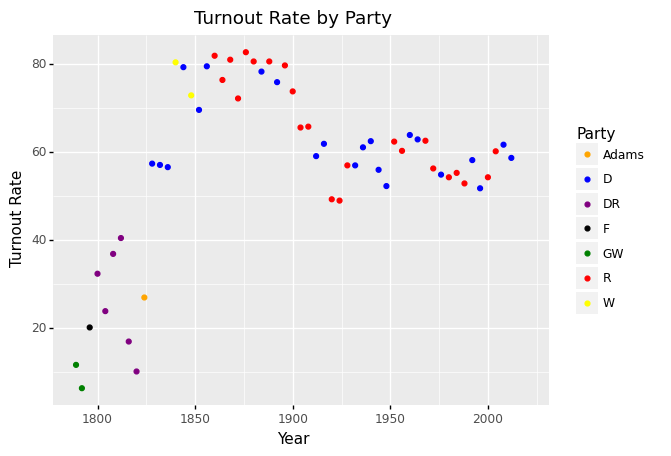

<ggplot: (8773181923633)>

In [11]:
# Turnout Rate each year by Party
(
    ggplot(total_data, aes(x = "Year", y = "Turnout Rate", color = "Party")) +
    geom_point() +
    labs(title = "Turnout Rate by Party") +
    scale_color_manual(values = ("Orange", "Blue", "Purple", "Black", "Green", "Red", "Yellow"))
)

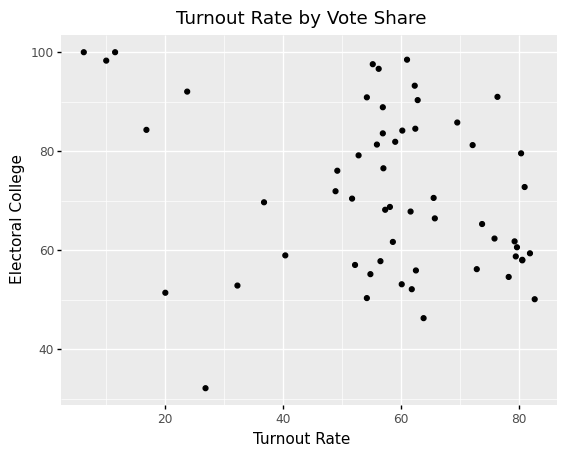

<ggplot: (8773181892738)>

In [12]:
# Turnout Rate by Vote Share
(
    ggplot(total_data, aes(x = "Turnout Rate", y = "Electoral College")) +
    geom_point() +
    labs(title = "Turnout Rate by Vote Share")
)

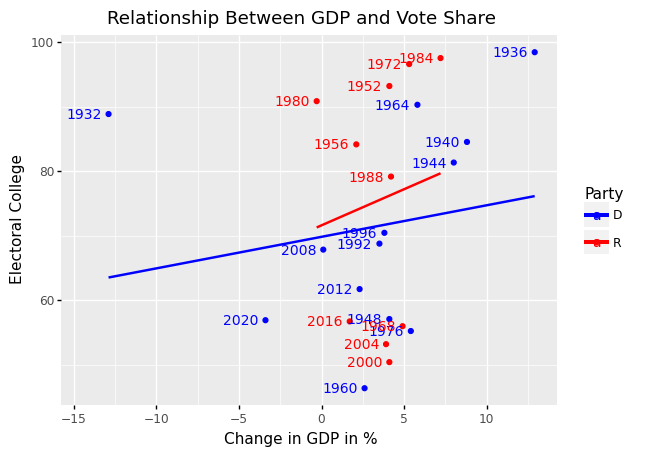

<ggplot: (8773190433564)>

In [13]:
# GDP and Vote Share
(
    ggplot(total_data[35:], aes(x = "Change in GDP in %", y = "Electoral College", color = "Party", label = "Year")) +
    geom_point() +
    geom_text(size = 10, nudge_x = -1.5) +
    labs(title = "Relationship Between GDP and Vote Share") +
    scale_color_manual(values = ("Blue", "Red")) +
    geom_smooth(method = 'lm', se = False)
)

## Challenges

- Have had to define some assumptions to make data simpler 

- Difficult to access some data - turnout by party

- Often necessary to change plans depending on available data

## Next Steps

- Will need to add previous president info

- Add modeling steps

- Compare relevance of features

    - Would expect the most accurate swing states significantly impact percentage of vote 
    
- Can also do some analysis on how the other features interact